## Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pickle
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')

from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, silhouette_score

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
from sklearn.preprocessing import LabelEncoder

## Export data

In [2]:
with open('Saved data/X_train.pickle', 'rb') as data:
    X_train = pickle.load(data)
    
with open('Saved data/X_test.pickle', 'rb') as data:
    X_test = pickle.load(data)

with open('Saved data/X_train_scaled.pickle', 'rb') as data:
    X_train_scaled = pickle.load(data)
    
with open('Saved data/X_test_scaled.pickle', 'rb') as data:
    X_test_scaled = pickle.load(data)
    
with open('Saved data/y_train.pickle', 'rb') as data:
    y_train = pickle.load(data)
    
with open('Saved data/y_test.pickle', 'rb') as data:
    y_test = pickle.load(data)
    
with open('Saved data/labels.pickle', 'rb') as data:
    labels = pickle.load(data)

## PCA

Text(0.5, 1.0, 'PCA Results')

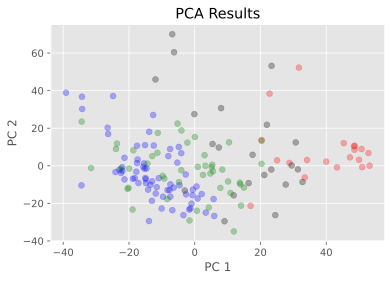

In [8]:
pca = PCA(n_components=4)
colors = ['red', 'black', 'blue', 'green']
pca.fit(X_train_scaled)
y_test1 = y_test.to_numpy().flatten()
res_pca = pca.transform(X_test_scaled)
unique_labels = np.unique(y_test1)
for index,unique_label in enumerate(unique_labels):
    X_data = res_pca[y_test1 == unique_label]
    plt.scatter(X_data[:,0], X_data[:,1],alpha=0.3,c=colors[index])
    
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("PCA Results")


In [3]:
pca = PCA(0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [4]:
with open('X_train_pca.pickle', 'wb') as output:
    pickle.dump(X_train_pca, output)
    
with open('X_test_pca.pickle', 'wb') as output:
    pickle.dump(X_test_pca, output)

## Autoencoder

In [14]:
# Построение входного слоя
input_layer = Input(shape =(X_train_scaled.shape[1], ))
  
# Построение сети кодировщика
encoded = Dense(5000, activation ='tanh',
                activity_regularizer = regularizers.l1(10e-5))(input_layer)
encoded = Dense(2500, activation ='tanh',
                activity_regularizer = regularizers.l1(10e-5))(encoded)
encoded = Dense(2000, activation ='tanh',
                activity_regularizer = regularizers.l1(10e-5))(encoded)
encoded = Dense(1000, activation ='tanh',
                activity_regularizer = regularizers.l1(10e-5))(encoded)
encoded = Dense(500, activation ='relu')(encoded)
  
# Построение сети декодера
decoded = Dense(1000, activation ='tanh')(encoded)
decoded = Dense(2000, activation ='tanh')(decoded)
decoded = Dense(2500, activation ='tanh')(decoded)
decoded = Dense(5000, activation ='tanh')(decoded)
  
# Построение выходного слоя
output_layer = Dense(X_train_scaled.shape[1], activation ='relu')(decoded)
# Определение параметров сети авто-кодировщика
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer ="adadelta", loss ="mse")
# Обучение сети авто-кодировщика
autoencoder.fit(X_train_scaled, X_train_scaled, 
                batch_size = 16, epochs = 10, 
                shuffle = True, validation_split = 0.20)

Epoch 1/10
70/70 [==============================] - 91s 1s/step - loss: 43.4900 - val_loss: 43.3011
Epoch 2/10
70/70 [==============================] - 90s 1s/step - loss: 43.1227 - val_loss: 42.9485
Epoch 3/10
70/70 [==============================] - 93s 1s/step - loss: 42.7455 - val_loss: 42.5434
Epoch 4/10
70/70 [==============================] - 92s 1s/step - loss: 42.3129 - val_loss: 42.0824
Epoch 5/10
70/70 [==============================] - 92s 1s/step - loss: 41.8232 - val_loss: 41.5629
Epoch 6/10
70/70 [==============================] - 93s 1s/step - loss: 41.2756 - val_loss: 40.9876
Epoch 7/10
70/70 [==============================] - 87s 1s/step - loss: 40.6734 - val_loss: 40.3589
Epoch 8/10
70/70 [==============================] - 84s 1s/step - loss: 40.0217 - val_loss: 39.6847
Epoch 9/10
70/70 [==============================] - 84s 1s/step - loss: 39.3276 - val_loss: 38.9712
Epoch 10/10
70/70 [==============================] - 82s 1s/step - loss: 38.5982 - val_loss: 38.2274

In [15]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])
hidden_representation.add(autoencoder.layers[3])
hidden_representation.add(autoencoder.layers[4])
hidden_representation.add(autoencoder.layers[5])

In [16]:
X_train_autoencoder = hidden_representation.predict(X_train_scaled)
X_test_autoencoder = hidden_representation.predict(X_test_scaled)

In [17]:
with open('Saved data/X_train_autoencoder.pickle', 'wb') as output:
    pickle.dump(X_train_autoencoder, output)
    
with open('Saved data/X_test_autoencoder.pickle', 'wb') as output:
    pickle.dump(X_test_autoencoder, output)